In [44]:
# STEP 1: Setup & Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [45]:
# STEP 2: Load & Clean Data
df = pd.read_csv("ev_charging_patterns.csv")

# Drop rows with missing target
df = df.dropna(subset=["Energy Consumed (kWh)"])

# Fill numerical missing values with median
numerical_cols = ["Charging Rate (kW)", "Distance Driven (since last charge) (km)"]
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

In [46]:
# Feature Engineering Enhancements

# Already done
df["SOC Delta (%)"] = df["State of Charge (End %)"] - df["State of Charge (Start %)"]

# NEW: Charging duration in minutes (if not already available in minutes)
df["Charging Duration (minutes)"] = df["Charging Duration (hours)"] * 60

# NEW: Normalized charging rate
df["Normalized Charging Rate"] = df["Charging Rate (kW)"] / df["Battery Capacity (kWh)"]
df["Normalized Charging Rate"] = df["Normalized Charging Rate"].fillna(0)  # avoid division by zero

# If any NaNs appeared, fix them
df.fillna(0, inplace=True)


In [47]:
# STEP 3: Feature Engineering
df["SOC Delta (%)"] = df["State of Charge (End %)"] - df["State of Charge (Start %)"]
df["Charging Duration (minutes)"] = df["Charging Duration (hours)"] * 60
df["Normalized Charging Rate"] = df["Charging Rate (kW)"] / df["Battery Capacity (kWh)"]
df["Normalized Charging Rate"] = df["Normalized Charging Rate"].fillna(0)
df.fillna(0, inplace=True)

In [48]:
# STEP 4: Remove Outliers (optional but recommended)
Q1 = df["Energy Consumed (kWh)"].quantile(0.25)
Q3 = df["Energy Consumed (kWh)"].quantile(0.75)
IQR = Q3 - Q1
df = df[(df["Energy Consumed (kWh)"] >= Q1 - 1.5 * IQR) & (df["Energy Consumed (kWh)"] <= Q3 + 1.5 * IQR)]



In [49]:
# STEP 5: Feature Selection
features = [
    "Battery Capacity (kWh)",
    "Charging Duration (hours)",
    "Charging Duration (minutes)",
    "Charging Rate (kW)",
    "Normalized Charging Rate",
    "Charging Cost (USD)",
    "State of Charge (Start %)",
    "State of Charge (End %)",
    "SOC Delta (%)",
    "Distance Driven (since last charge) (km)",
    "Temperature (°C)",
    "Vehicle Age (years)"
]
target = ["Energy Consumed (kWh)"]

In [50]:
# STEP 6: Scale & Split
X = df[features].values
y = df[target].values

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape for GRU input
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [51]:
# STEP 7: Define Optimized GRU Model
model = Sequential([
    GRU(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.Huber(),
              metrics=['mae'])

model.summary()


c:\Users\mugal\common_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_5 (GRU)                     │ (None, 64)             │        14,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,249 (83.00 KB)

 Trainable params: 21,249 (83.00 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=300,
    batch_size=32,
    verbose=1,
    
)

Epoch 1/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0688 - mae: 0.3140 - val_loss: 0.0303 - val_mae: 0.2122
Epoch 2/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0251 - mae: 0.1862 - val_loss: 0.0265 - val_mae: 0.2031
Epoch 3/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0243 - mae: 0.1827 - val_loss: 0.0271 - val_mae: 0.2035
Epoch 4/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0235 - mae: 0.1824 - val_loss: 0.0266 - val_mae: 0.2024
Epoch 5/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0241 - mae: 0.1843 - val_loss: 0.0262 - val_mae: 0.2009
Epoch 6/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0242 - mae: 0.1853 - val_loss: 0.0260 - val_mae: 0.1999
Epoch 7/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0242 - mae: 0.1833 - val_loss: 0.0264 - val_mae: 0.2015
Epoch 8/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0238 - mae: 0.1844 - val_loss: 0.0261 - val_mae: 0.2003
Epoch 9/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.02

In [53]:
# STEP 9: Evaluate Model
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_test_original, y_pred)
mape = mean_absolute_percentage_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
r2 = r2_score(y_test_original, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
MAE: 19.54
MAPE: 97.99%
RMSE: 23.17
R² Score: -0.0782


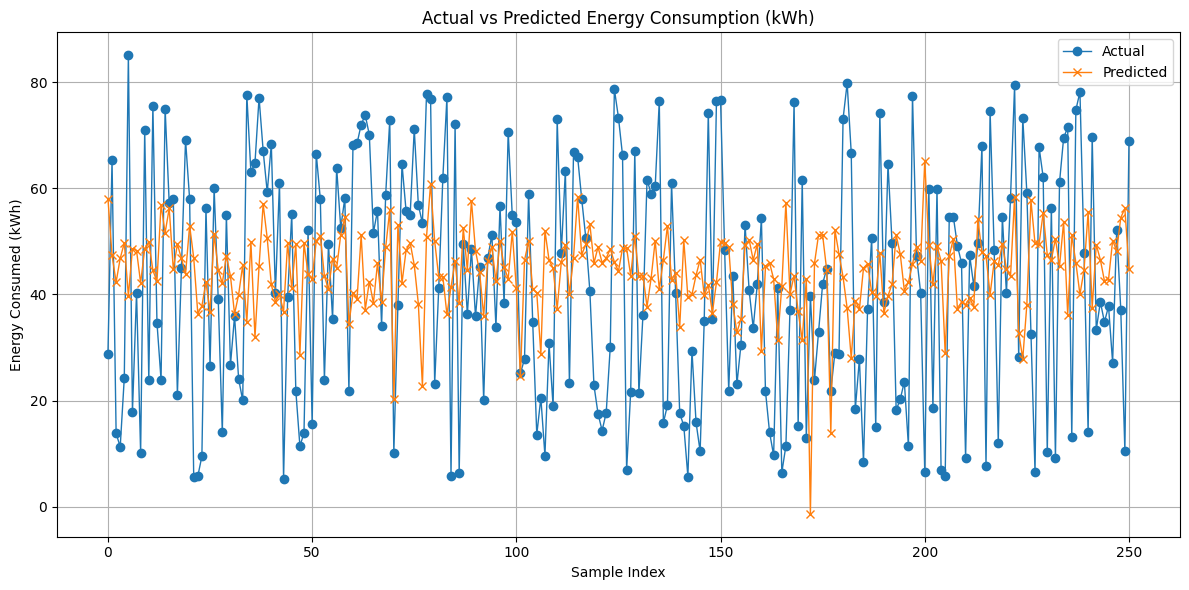

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_original.flatten(), label='Actual', marker='o', linewidth=1)
plt.plot(y_pred.flatten(), label='Predicted', marker='x', linewidth=1)
plt.title("Actual vs Predicted Energy Consumption (kWh)")
plt.xlabel("Sample Index")
plt.ylabel("Energy Consumed (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

MAE: 18.96
MAPE: 73.56%
RMSE: 23.00
R² Score: -0.1687


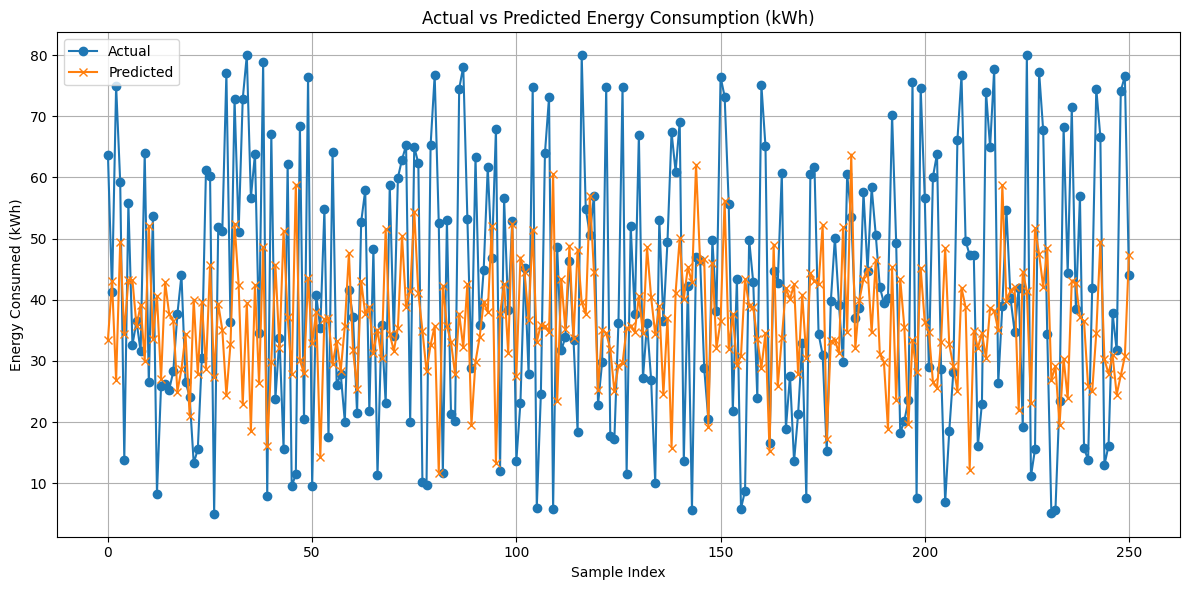

In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("ev_charging_patterns.csv")

# Drop rows with missing target
df = df.dropna(subset=["Energy Consumed (kWh)"])

# Fill missing values
numerical_cols = ["Charging Rate (kW)", "Distance Driven (since last charge) (km)"]
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

# Feature engineering
df["SOC Delta (%)"] = df["State of Charge (End %)"] - df["State of Charge (Start %)"]
df["Charging Duration (minutes)"] = df["Charging Duration (hours)"] * 60
df["Normalized Charging Rate"] = df["Charging Rate (kW)"] / df["Battery Capacity (kWh)"]
df["Normalized Charging Rate"] = df["Normalized Charging Rate"].fillna(0)
df.fillna(0, inplace=True)

# Feature list
features = [
    "Battery Capacity (kWh)",
    "Charging Duration (hours)",
    "Charging Duration (minutes)",
    "Charging Rate (kW)",
    "Normalized Charging Rate",
    "Charging Cost (USD)",
    "State of Charge (Start %)",
    "State of Charge (End %)",
    "SOC Delta (%)",
    "Distance Driven (since last charge) (km)",
    "Temperature (°C)",
    "Vehicle Age (years)"
]

target = "Energy Consumed (kWh)"

# Input/output
X = df[features].values
y = df[target].values.reshape(-1, 1)

# Log transform target (if needed)
y_log = np.log1p(y)

# Scaling
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y_log)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# XGBoost model
model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train.ravel())

# Predictions
y_pred_scaled = model.predict(X_test).reshape(-1, 1)

# Inverse scaling and log transform
y_pred = np.expm1(scaler_y.inverse_transform(y_pred_scaled))
y_test_original = np.expm1(scaler_y.inverse_transform(y_test))

# Evaluation
mae = mean_absolute_error(y_test_original, y_pred)
mape = mean_absolute_percentage_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
r2 = r2_score(y_test_original, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test_original.flatten(), label='Actual', marker='o')
plt.plot(y_pred.flatten(), label='Predicted', marker='x')
plt.title("Actual vs Predicted Energy Consumption (kWh)")
plt.xlabel("Sample Index")
plt.ylabel("Energy Consumed (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [56]:
!pip install xgboost

  Using cached xgboost-3.0.2-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.2-py3-none-win_amd64.whl (150.0 MB)
